In [1]:
import numpy as np
import pandas as pd

In [2]:
ny = pd.read_csv("static-data/nyc-age-stats.csv")
assert ny.columns.tolist() == ['AGE_GROUP', 'Cases', 'Hospitalizations', 'Deaths']
assert ny.AGE_GROUP.tolist() == ['0-17', '18-44', '45-64', '65-74', '75+', 'Citywide']
drop = ny.AGE_GROUP == "Citywide"
ny = ny[~drop]
ny["min_age"] = [0, 18, 45, 65, 75]
ny["max_age"] = [17, 44, 64, 74, 99]
ny = ny.drop(columns=["AGE_GROUP"])
ny.columns = ["cases", "hosp", "deaths", "min_age", "max_age"]
ny

,cases,hosp,deaths,min_age,max_age
0,384.33,34.22,0.75,0,17
1,2468.39,270.17,21.28,18,44
2,3863.43,911.99,206.27,45,64
3,3824.68,1760.36,669.99,65,74
4,4634.95,2817.86,1691.12,75,99


ages static HTML file from https://www.baruch.cuny.edu/nycdata/population-geography/age_distribution.htm

From saved HTML file on disk from https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Sweden#Statistics

In [3]:
def _get_ages(row, age_dist=None, catch=True):
    idx = (row.min_age <= age_dist.min_age) & (age_dist.max_age <= row.max_age)
    if catch:
        assert idx.sum() == 2
    return age_dist.loc[idx, "population"].sum()

In [4]:
nyc_pop =  8622698

ny_ages = pd.read_html("static-data/age_distribution.htm")
assert len(ny_ages) == 1
ny_age = ny_ages[0]
ny_age.columns = ny_age.iloc[1]
assert "NYC" in ny_age.columns[2]
ny_age = ny_age.iloc[:, [1, 2]]
ny_age = ny_age.iloc[11:-9]
ny_age = ny_age.reset_index(drop=True)
ny_age.columns = ["age", "percent"]
ny_age.loc[0, "age"] = "0 to 5 years"
ny_age.loc[len(ny_age) - 1, "age"] = "85 to 99 years"
ny_age["min_age"] = ny_age["age"].apply(lambda x: int(x.split(" ")[0]))
ny_age["max_age"] = ny_age["age"].apply(lambda x: int(x.split(" ")[2]))
ny_age["percent"] = ny_age["percent"].apply(lambda x: float(x.replace("%", "")) / 100)
assert np.allclose(ny_age["percent"].sum(), 1.001)
ny_age["population"] = ny_age["percent"] * nyc_pop

ny["population"] = ny[["min_age", "max_age"]].apply(_get_ages, axis=1, age_dist=ny_age, catch=False)
# assert np.allclose(ny["population"].sum(), 1.001 * nyc_pop)

ny.head()

,cases,hosp,deaths,min_age,max_age,population
0,384.33,34.22,0.75,0,17,1508972.150
1,2468.39,270.17,21.28,18,44,3311116.032
2,3863.43,911.99,206.27,45,64,2112561.010
3,3824.68,1760.36,669.99,65,74,689815.840
4,4634.95,2817.86,1691.12,75,99,551852.672


In [5]:
ny["population"].sum() / nyc_pop

0.948

In [6]:
data = {
    "cases": [494, 3276, 11592, 12152, 13300, 14399, 8281, 5835, 6521, 3526],
    "deaths": [1, 0, 8, 16, 45, 159, 389, 1229, 2367, 1486],
    "icu": [8, 15, 91, 116, 281, 638, 756, 494, 102, 3],
    "age range": ["0-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89", "90-99"],
}
sweden = pd.DataFrame(data)

`Sweden-2017.csv` form https://www.populationpyramid.net/sweden/2017/

In [7]:
swe_ages = pd.read_csv("static-data/Sweden-2017.csv")
assert swe_ages.columns.tolist() == ["Age", "M", "F"]
swe_ages.columns = ["age", "m", "f"]
swe_ages = swe_ages.set_index("age").sum(axis=1)
swe_ages = swe_ages.reset_index()
swe_ages.loc[swe_ages["age"] == "100+", "age"] = "100-109"
swe_ages.columns = ["age", "population"]
swe_ages["min_age"] = swe_ages["age"].apply(lambda x: int(x.split("-")[0]))
swe_ages["max_age"] = swe_ages["age"].apply(lambda x: int(x.split("-")[1]))
# swe_ages.head()

In [8]:
sweden["min_age"] = sweden["age range"].apply(lambda x: int(x.split("-")[0]))
sweden["max_age"] = sweden["age range"].apply(lambda x: int(x.split("-")[1]))

sweden["population"] = sweden[["min_age", "max_age"]].apply(_get_ages, age_dist=swe_ages, axis=1)
sweden = sweden.drop(columns=["age range"])
sweden.head()

,cases,deaths,icu,min_age,max_age,population
0,494,1,8,0,9,1180854
1,3276,0,15,10,19,1053362
2,11592,8,91,20,29,1354095
3,12152,16,116,30,39,1239983
4,13300,45,281,40,49,1310020


Compare fraction of population that's dead/in ICU.

In [9]:
for v in ["deaths", "cases", "icu"]:
    k = v
    if v[-1] == "s":
        k = v[:-1]
    sweden[f"{k}_rate"] = sweden[v] / sweden["population"]
    if k != "icu":
        ny[f"{k}_rate"] = ny[v] / ny["population"]

ny["region"] = "NYC"
sweden["region"] = "Sweden"

In [10]:
ny.head()

,cases,hosp,deaths,min_age,max_age,population,death_rate,case_rate,region
0,384.33,34.22,0.75,0,17,1508972.150,4.970271e-07,0.000255,NYC
1,2468.39,270.17,21.28,18,44,3311116.032,6.426836e-06,0.000745,NYC
2,3863.43,911.99,206.27,45,64,2112561.010,9.763978e-05,0.001829,NYC
3,3824.68,1760.36,669.99,65,74,689815.840,9.712592e-04,0.005544,NYC
4,4634.95,2817.86,1691.12,75,99,551852.672,3.064441e-03,0.008399,NYC


From https://www.populationpyramid.net/united-states-of-america/

In [76]:
us_ages = pd.read_csv("static-data/us-age-pyramid.csv")
us_ages = us_ages.set_index("Age")
us_ages = us_ages.sum(axis=1).reset_index()
us_ages.columns = ["age", "population"]
us_ages = us_ages.set_index("age")
us_ages.loc["95-99"] += us_ages.loc["100+"]
us_ages = us_ages.drop("100+").reset_index()
us_ages.columns = ["age", "population"]
us_ages["min_age"] = us_ages.age.apply(lambda x: int(x.split("-")[0]))
us_ages["max_age"] = us_ages.age.apply(lambda x: int(x.split("-")[1]))
us_ages.tail()

,age,population,min_age,max_age
15,75-79,9727734,75,79
16,80-84,6461202,80,84
17,85-89,3911104,85,89
18,90-94,2051136,90,94
19,95-99,723740,95,99


From https://en.wikipedia.org/wiki/COVID-19_pandemic_in_the_United_States, current as of .S. Centers for Disease Control and Prevention ([422])
Data as of 2020/07/22. , from 

[422]:https://data.cdc.gov/NCHS/Provisional-COVID-19-Death-Counts-by-Sex-Age-and-S/9bhg-hcku

In [202]:
us = pd.read_html("static-data/us-deaths-by-age.html")[0]
us = us.iloc[1:-1, 1:]
us.columns = ["age", "deaths", "percentage"]
us.loc[us.age == "Under 1", "age"] = "0-1"
us.loc[us.age == "85 and over", "age"] = "85-100"
us = us.set_index("age").drop(columns="percentage")
us["deaths"] = us["deaths"].astype(int)
us.loc["1-4"] += us.loc["0-1"]
us = us.drop("0-1")
us.loc["0-4"] = us.loc["1-4"]
us = us.drop("1-4")
us = us.reset_index()

us["min_age"] = us.age.apply(lambda x: int(x.split("-")[0]))
us["max_age"] = us.age.apply(lambda x: int(x.split("-")[1]))

us["population"] = us.apply(_get_ages, age_dist=us_ages, catch=False, axis=1)
us.population.sum()
assert 331e6 <= us.population.sum() <= 331.1e6
us.to_csv("data/us-covid-deaths.csv", index=False)
us = us.drop(columns=["age"]).melt(id_vars=["deaths", "population"], value_name="age").drop(columns="variable")
us["region"] = "US"
us["deaths"] = us["deaths"].astype(int)
us["death_rate"] = us["deaths"] / us["population"]

us.head()

,deaths,population,age,region,death_rate
0,16,41134639,5,US,3.889666e-07
1,190,43501653,15,US,4.367650e-06
2,935,46887809,25,US,1.994122e-05
3,2411,41910390,35,US,5.752750e-05
4,6566,40631605,45,US,1.615983e-04


In [138]:
df = pd.concat((ny, sweden, us))

df = df.melt(id_vars=[c for c in df.columns if "age" not in c], value_name="age")

df = df[["death_rate", "case_rate", "age", "region", "icu_rate"]]
df.head(n=3)

,death_rate,case_rate,age,region,icu_rate
0,4.970271e-07,0.000255,0.0,NYC,NaN
1,6.426836e-06,0.000745,18.0,NYC,NaN
2,9.763978e-05,0.001829,45.0,NYC,NaN


In [139]:
mn = pd.read_csv("data/mn-covid-data.csv")
mn = mn[mn.virus == "covid"].fillna(0)
mn["icu_rate"] = mn["icu"] / mn["population"]
mn["death_rate"] = mn["deaths"] / mn["population"]
mn["case_rate"] = mn["num_cases"] / mn["population"]
mn = mn.drop(columns=["age_range"])
mn = mn.melt(id_vars=[c for c in mn.columns if "age" not in c], value_name="age").drop(columns="variable")
mn["region"] = "MN"

df = pd.concat((df, mn))
df.region.unique()

array(['NYC', 'Sweden', 'US', 'MN'], dtype=object)

In [140]:
df.sample(n=5)

,death_rate,case_rate,age,region,icu_rate,num_cases,hosp,icu,deaths,hosp_rate,virus,population,illness_rate
100,0.000376,NaN,64.0,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,0.000098,0.001829,NaN,NYC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,0.000004,0.017380,29.0,MN,0.000074,12728.0,394.0,54.0,3.0,0.030955,covid,732327.0,0.01738
22,0.002125,NaN,NaN,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,0.000058,NaN,35.0,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [141]:
df.region.unique()

array(['NYC', 'Sweden', 'US', 'MN'], dtype=object)

In [142]:
df[df.region == "Sweden"].head()

,death_rate,case_rate,age,region,icu_rate,num_cases,hosp,icu,deaths,hosp_rate,virus,population,illness_rate
5,8.468447e-07,0.000418,0.0,Sweden,0.000007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.000000e+00,0.003110,10.0,Sweden,0.000014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,5.908005e-06,0.008561,20.0,Sweden,0.000067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1.290340e-05,0.009800,30.0,Sweden,0.000094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3.435062e-05,0.010153,40.0,Sweden,0.000215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


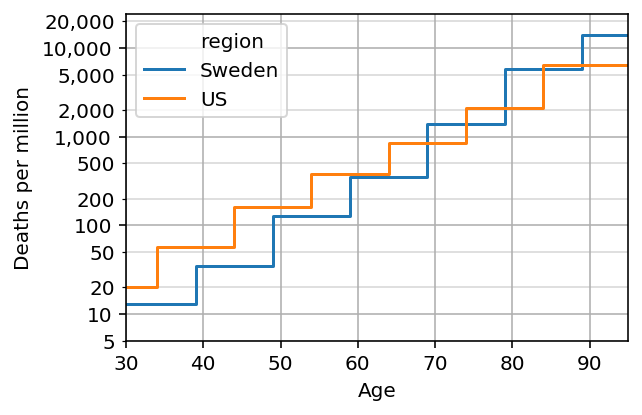

In [194]:
import seaborn as sns
import matplotlib.pyplot as plt

df["death_rate_per_million"] = 1e6 * df["death_rate"]
df["case_rate_per_million"] = 1e6 * df["case_rate"]
df["icu_rate_per_million"] = 1e6 * df["icu_rate"]

w = 3
fig, ax = plt.subplots(figsize=(1.5 * w, w))

ax = sns.lineplot(
    x="age",
    y="death_rate_per_million",
    hue="region",
    hue_order=["Sweden", "US"],
    data=df[df.region.isin(["Sweden", "US"])],
    drawstyle="steps-pre",
)

# s = df[df.region == "US"].copy()
# s = s.sort_values(by="age")
# ax.plot(s.age, s.death_rate_per_million, "C2--", label="US", drawstyle="steps-pre")

ax.set_yscale("log")
ax.set_ylabel("Deaths per million")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))
minor_yticks = [[2 * 10**i, 5*10**i] for i in range(10)]
ax.yaxis.set_minor_locator(plt.FixedLocator(sum(minor_yticks, [])))
ax.yaxis.set_minor_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))
ax.set_xlabel("Age")
ax.grid(alpha=1.0)
ax.grid(alpha=0.5, which="minor", axis="y")
ax.legend(loc="best")
ax.set_xlim(0, 89)

ax.set_xlim(30, 95)
ax.set_ylim(5, None)

# yticks = [[1 * 10**i, 2*10**i, 5*10**i] for i in range(0, 5)]
# ax.yaxis.set_major_locator(plt.FixedLocator(sum(yticks, [])))

ages = np.arange(1, 100)
y = 10 ** (0.05 * ages)
# line1, = ax.plot(ages, 0.20 * y, "C1--", label="NYC fit")
# line2, = ax.plot(ages, 0.26 * y, "C0--", label="Sweden fit")
# ax.legend(handles=(line1, line2), loc="lower right")
fig.savefig("imgs/deaths-nyc-us-sweden.png", dpi=300, bbox_inches="tight")

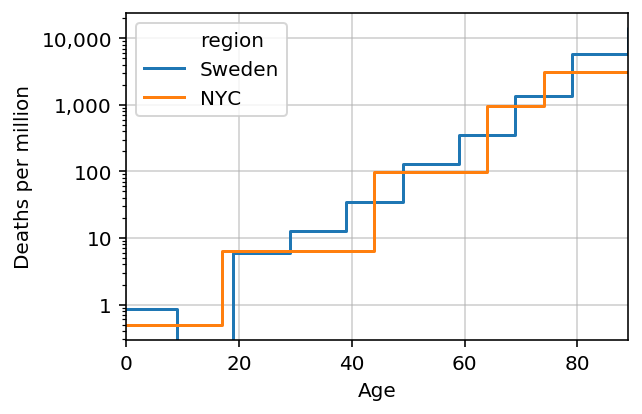

In [161]:
import seaborn as sns
import matplotlib.pyplot as plt

df["death_rate_per_million"] = 1e6 * df["death_rate"]
df["case_rate_per_million"] = 1e6 * df["case_rate"]
df["icu_rate_per_million"] = 1e6 * df["icu_rate"]

w = 3
fig, ax = plt.subplots(figsize=(1.5 * w, w))

ax = sns.lineplot(
    x="age",
    y="death_rate_per_million",
    hue="region",
    hue_order=["Sweden", "NYC"],
    data=df[df.region.isin(["Sweden", "NYC"])],
    drawstyle="steps-pre",
)
ax.set_yscale("log")
ax.set_ylabel("Deaths per million")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))
ax.set_xlabel("Age")
ax.grid(alpha=0.6)
ax.legend(loc="best")
ax.set_xlim(0, 89)
# yticks = [[1 * 10**i, 2*10**i, 5*10**i] for i in range(0, 5)]
# ax.yaxis.set_major_locator(plt.FixedLocator(sum(yticks, [])))

ages = np.arange(1, 100)
y = 10 ** (0.05 * ages)
# line1, = ax.plot(ages, 0.20 * y, "C1--", label="NYC fit")
# line2, = ax.plot(ages, 0.26 * y, "C0--", label="Sweden fit")
# ax.legend(handles=(line1, line2), loc="lower right")
fig.savefig("imgs/deaths-nyc-sweden.png", dpi=300, bbox_inches="tight")

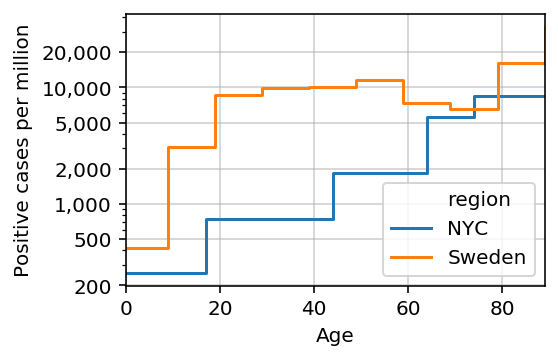

In [60]:
w = 2.5
fig, ax = plt.subplots(figsize=(1.5 * w, w))
ax = sns.lineplot(
    x="age",
    y="case_rate_per_million",
    hue="region",
    data=df[df.region.isin(["NYC", "Sweden"])],
    drawstyle="steps-pre",
)
ax.set_yscale("log")
ax.set_ylabel("Positive cases per million")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))
ax.set_xlabel("Age")
yticks = [[1 * 10**i, 2*10**i, 5*10**i] for i in range(0, 5)]
ax.yaxis.set_major_locator(plt.FixedLocator(sum(yticks, [])))
ax.set_xlim(0, 89)
# ages = np.arange(1, 100)
# ax.plot(ages, 200 * 10 ** (0.02 * ages))

ax.grid(alpha=0.6)
fig.savefig("imgs/cases-nyc-sweden.png", dpi=300, bbox_inches="tight")

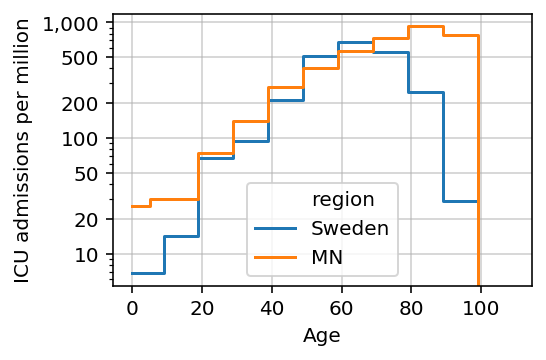

In [18]:
w = 2.5
fig, ax = plt.subplots(figsize=(1.5 * w, w))
ax = sns.lineplot(
    x="age",
    y="icu_rate_per_million",
    hue="region",
    data=df[df.region.isin(["Sweden", "MN"])],
    drawstyle="steps-pre",
)
ax.set_yscale("log")
ax.set_ylabel("ICU admissions per million")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))
ax.set_xlabel("Age")
yticks = [[1 * 10**i, 2*10**i, 5*10**i] for i in range(0, 5)]
ax.yaxis.set_major_locator(plt.FixedLocator(sum(yticks, [])))

ax.grid(alpha=0.6)
fig.savefig("imgs/icu-mn-sweden.png", dpi=300, bbox_inches="tight")